In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import tensorflow as tf

In [22]:
path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/benign/adenosis/'

INPUT_SHAPE = 64

In [23]:
images = []
read = lambda imname: np.asarray(Image.open(imname).convert('L')) #'LA', 'L'

for image in os.listdir(path):

    img = read(path + "/" + image)
    # img = cv2.imread(path + folder + "/" + image)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE))

    # täusche RGB Image an damit das fürs ResNet als input verwendet werden kann
    img = np.repeat(img[..., np.newaxis], 3, -1)

    images.append(np.array(img))

In [24]:
#Image shape
images = np.array(images) / 255
X_train = images

In [25]:
print(X_train.shape)

(114, 64, 64, 3)


# **Data Visualization**

In [ ]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    
    for j in range(5):

            ax[i,j].imshow(X_train[idx].reshape(64,64,3))
            #ax[i,j].set_title("Real Image")
            
            idx+=600
            
plt.tight_layout()
plt.show()

# **Generator**

In [26]:
noise_shape = 100

In [27]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

In [28]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 256)        2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)     

# **Discriminator**

In [29]:
discriminator=Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [30]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        1568      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                      

# **DCGAN (combined model)**

In [31]:
GAN = Sequential([generator,discriminator])

In [32]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [33]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [34]:
GAN.layers

In [35]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64, 64, 3)         3585219   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 695009    
                                                                 
Total params: 4,280,228
Trainable params: 3,584,323
Non-trainable params: 695,905
_________________________________________________________________


# **Training**

In [59]:
epochs = 2000  #set epoch according to your training dataset size,i had chosen 50k images hence epochs are high as 300...
batch_size = 16 #128

In [60]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

In [ ]:
# def create_checkpoint(cp_path, gen_opt, disc_opt, gen, disc):

#     checkpoint_prefix = os.path.join(cp_path, "ckpt")
#     checkpoint = tf.train.Checkpoint(generator=gen,
#                                      discriminator=disc)
#     return checkpoint

# CHECKPOINT_PATH = './checkpoints/'

# checkpoint = create_checkpoint(CHECKPOINT_PATH, generator, discriminator)

# checkpoint_prefix = os.path.join(CHECKPOINT_PATH, "ckpt")

# checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))

# # saving (checkpoint) the model every 15 epochs
# if (epoch + 1) % 300 == 0:  # das auf 15 ändern

#     # checkpoint.save(file_prefix = checkpoint_prefix)
#     checkpoint.save(file_prefix=checkpoint_prefix)

Currently on Epoch 500
1/1 [==============================] - 0s 45ms/step


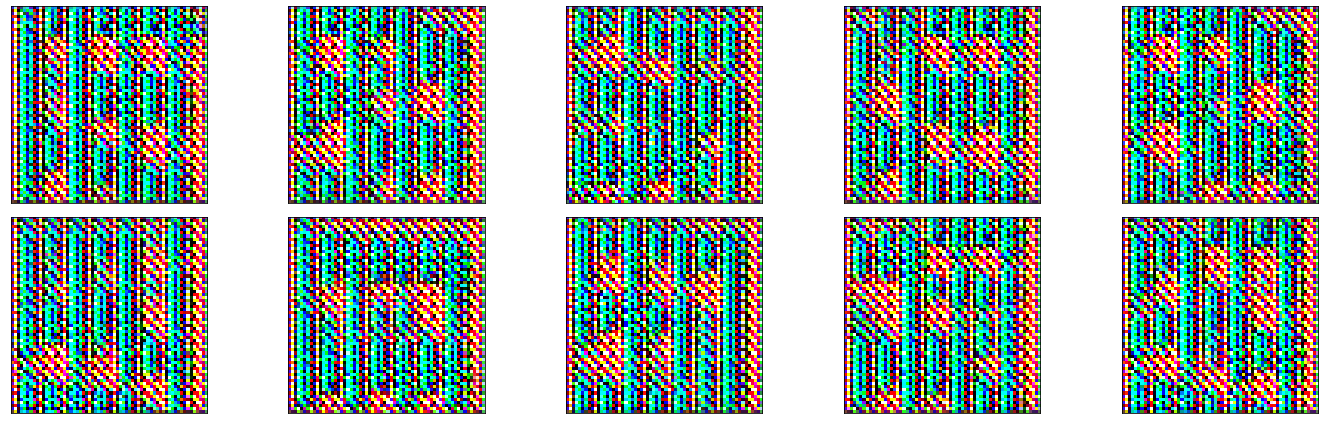

Currently on Epoch 1000
1/1 [==============================] - 0s 64ms/step


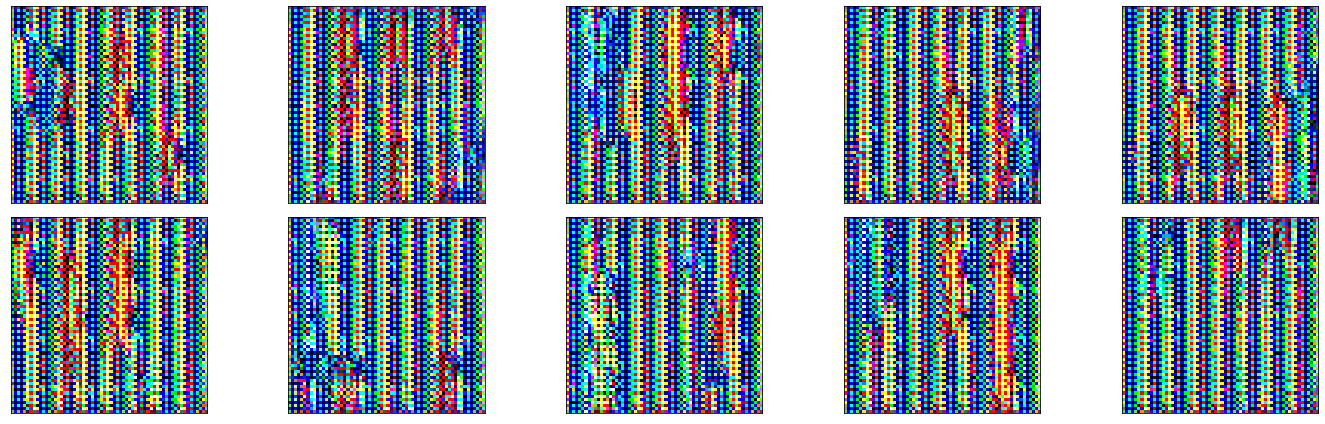

Currently on Epoch 1500
1/1 [==============================] - 0s 41ms/step


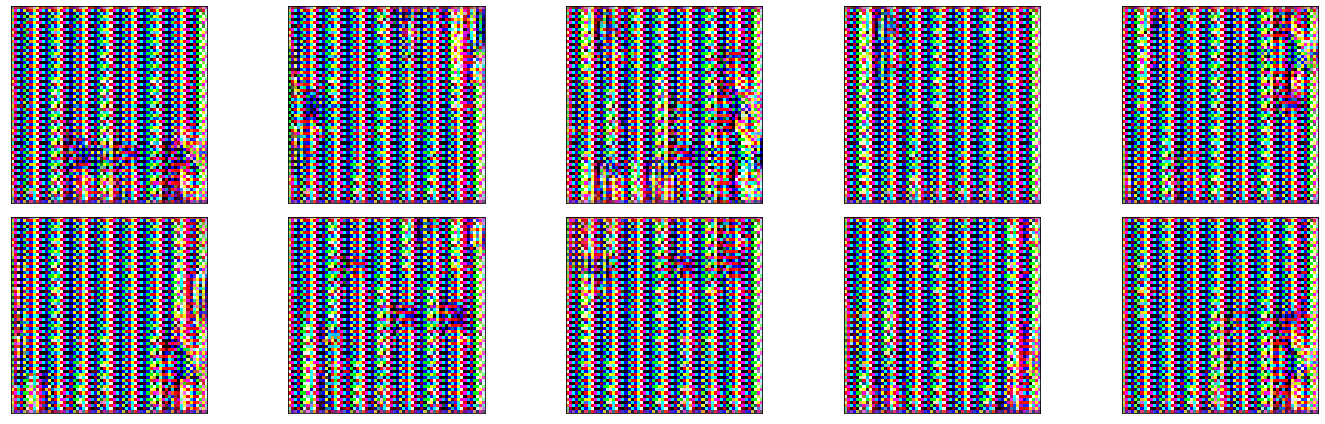

Currently on Epoch 2000
1/1 [==============================] - 0s 50ms/step


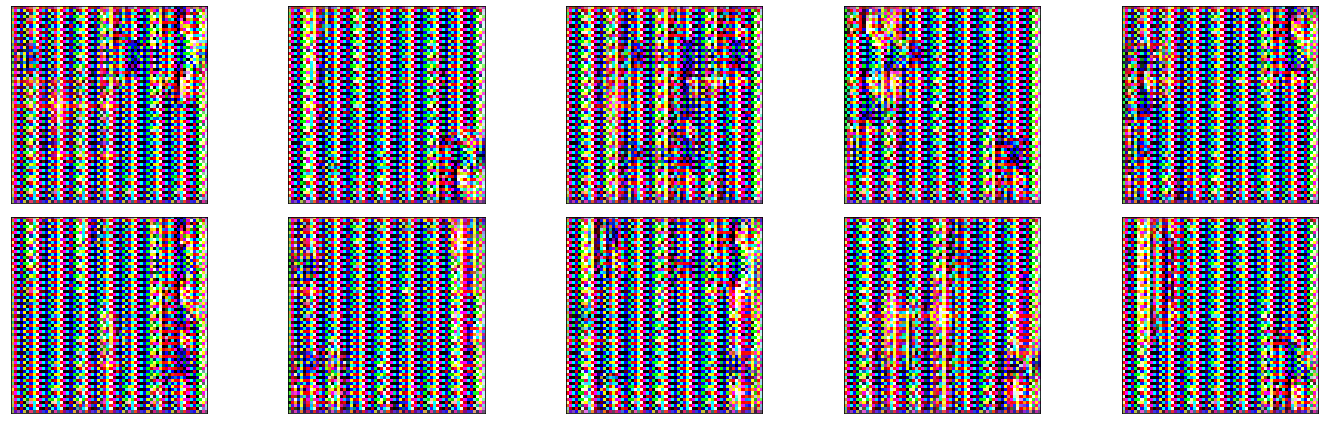

Training is complete


In [61]:
import matplotlib.pyplot as plt

for epoch in range(1, epochs+1):

    if epoch % 500 == 0:

        print(f"Currently on Epoch {epoch}")

    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        # if (i)%100 == 0:

        #     print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False

        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
            
    if epoch % 500 == 0:

        samples = 10
        x_fake = generator.predict(np.random.normal(loc = 0, scale=1, size = (samples,100)))

        for k in range(samples):

            plt.rcParams["figure.figsize"] = (20, 6)
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
        
    # print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))      

print('Training is complete')

# **Output Visualization**

In [62]:
noise=np.random.uniform(-1,1,size=[500,noise_shape])

In [63]:
im=generator.predict(noise)

16/16 [==============================] - 1s 79ms/step


4/4 [==============================] - 0s 59ms/step


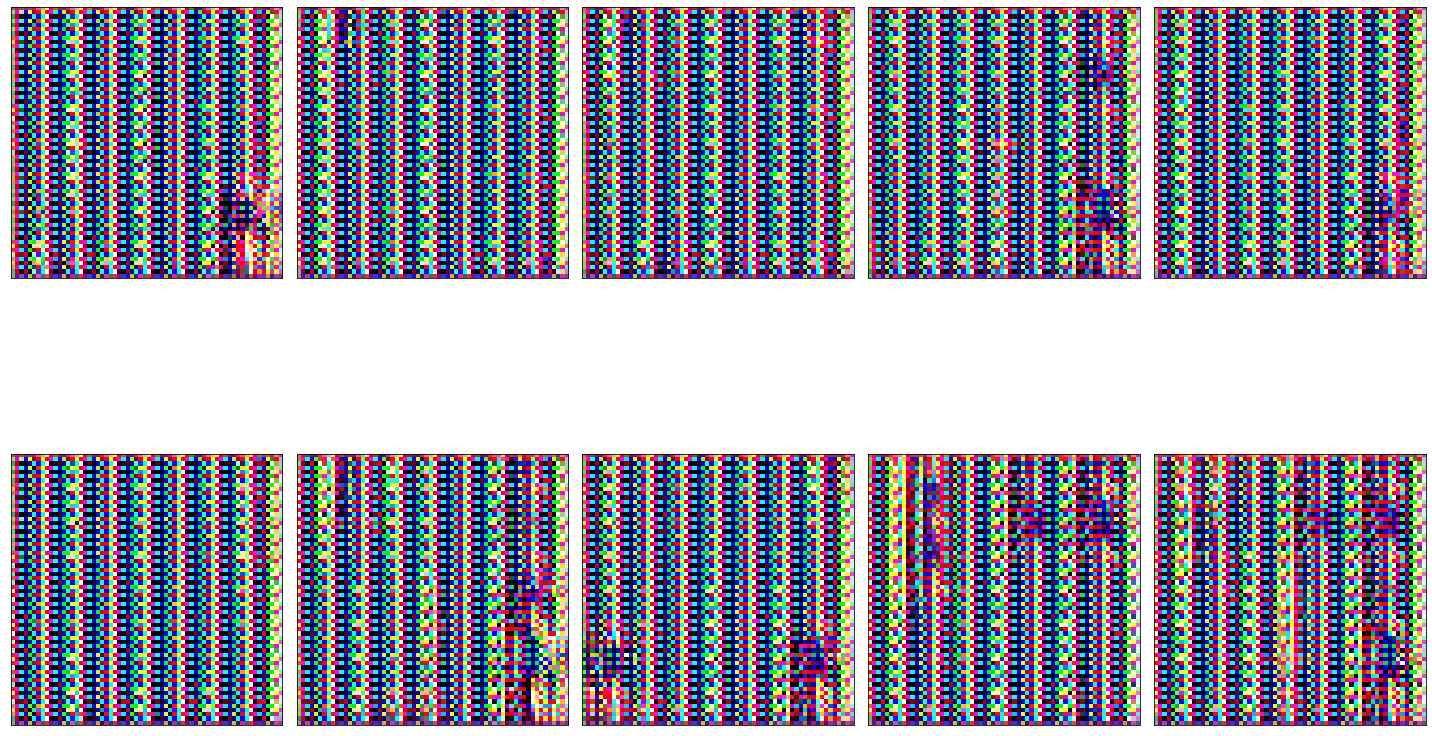

4/4 [==============================] - 0s 55ms/step


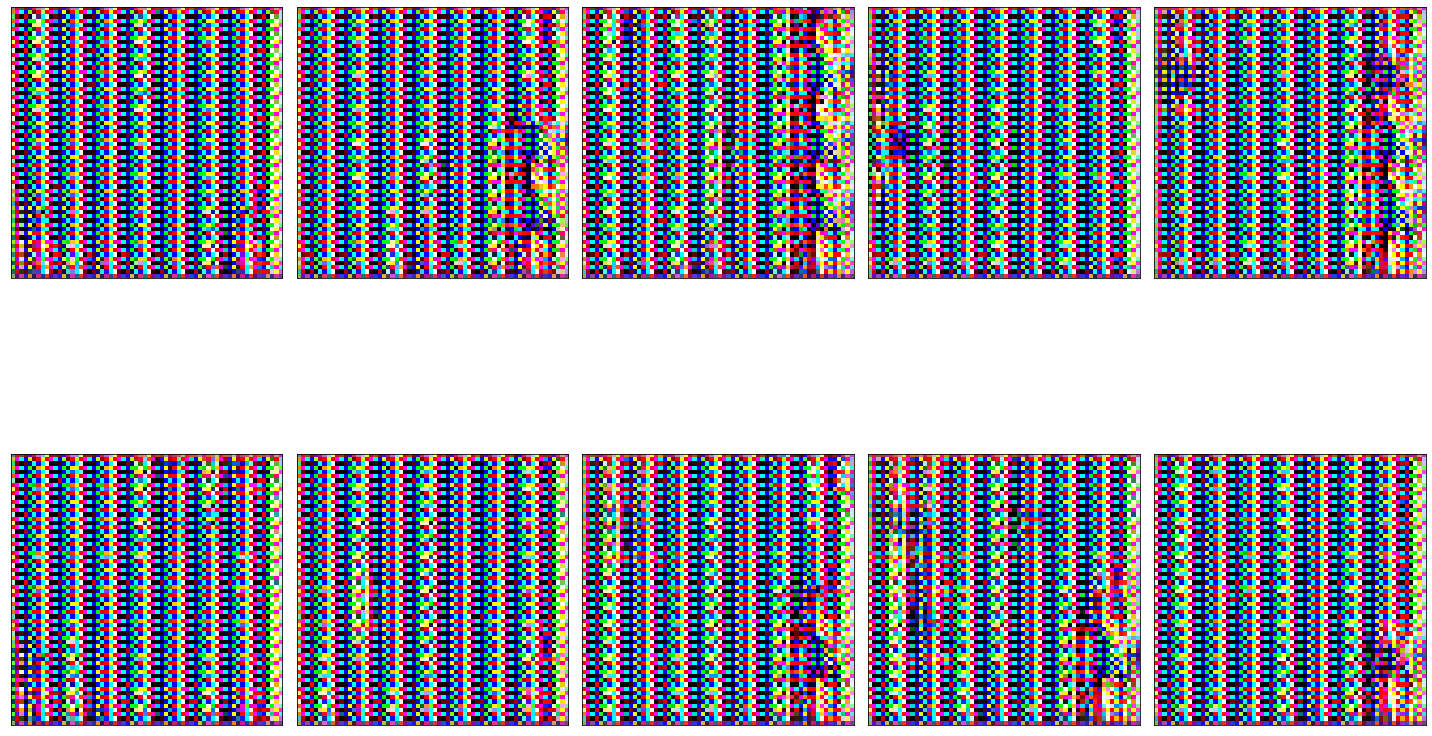

In [66]:
for i in range(2):

 plt.figure(figsize=(20,15)) 

 for k in range(10):

            noise=np.random.uniform(-1,1,size=[100,noise_shape])
            im=generator.predict(noise) 
            plt.subplot(2, 5, k+1)
            plt.imshow(im[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()

# **Loss Curve**

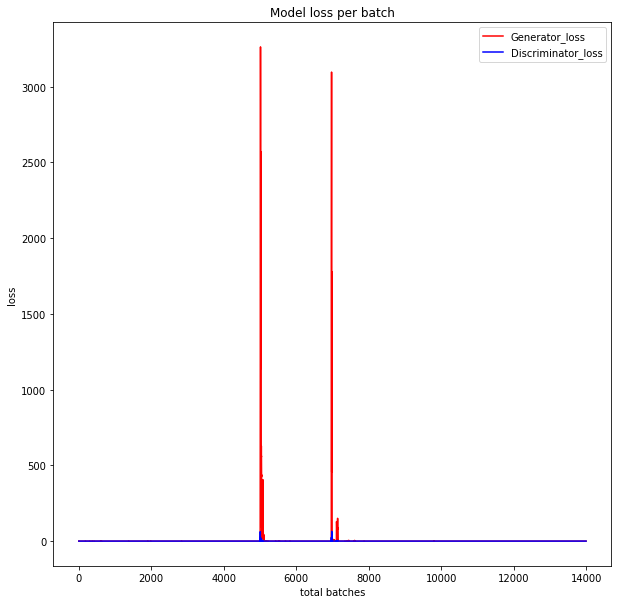

In [67]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

In [68]:
import pickle
Pkl_Filename = "DCGAN.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(GAN, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\sequential
......vars
...layers\sequential\layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\sequential\layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\sequential\layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\sequential\layers\conv2d_transpose
......vars
.........0
.........1
...layers\sequential\layers\conv2d_transpose_1
......vars
.........0
.........1
...layers\sequential\layers\conv2d_transpose_2
......vars
.........0
.........1
...layers\sequential\layers\conv2d_transpose_3
......vars
.........0
.........1
...layers\sequential\layers\dense
......vars
.........0
.........1
...layers\sequential\layers\leaky_re_lu
......vars
...layers\sequential\layers\leaky_re_lu_1
......vars
...layers\sequential\layers\leaky_re_lu_2
......vars
...layers\sequential\layers\reshape
......vars
